In [1]:
import pandas as pd
#pd.set_option("display.max_rows", None, "display.max_columns", None)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import statistics
import statsmodels.api as sm
from itertools import permutations
#import pdfkit as pdf

import seaborn as sns; sns.set(style="ticks", color_codes=True)
#iris = sns.load_dataset("iris")
#g = sns.pairplot(iris)

from Bio import SeqIO
import sys

#%load_ext rpy2.ipython

In [49]:
# The list of mtDNA protein-coding genes.
list_mtdna = [ 'MT-ND1','MT-ND2','MT-CO1','MT-CO2','MT-ATP8','MT-ATP6','MT-CO3','MT-ND3','MT-ND4L','MT-ND4','MT-CYB','MT-ND5','MT-ND6'
             ,'MT-ATP8_MT-ATP6','MT-ND4L_MT-ND4' ]

# The list of SRR samples used.
list_SRR = ['SRR1074719','SRR1077288','SRR1077805','SRR1080766','SRR1327327','SRR1365448']

In [132]:
# Connecting SRR ID to more info.
dict_info = {   'SRR1074719':['GTEX-XPVG','EuAm','Male','Muscle - Skeletal'],
                'SRR1077288':['GTEX-SSA3','AfAm','Male','Muscle - Skeletal'],
                'SRR1077805':['GTEX-XYKS','AfAm','Female','Muscle - Skeletal'],
                'SRR1080766':['GTEX-XUZC','EuAm','Female','Muscle - Skeletal'],
                'SRR1365448':['GTEX-11WQC','AfAm','Male','Muscle - Skeletal'],
                'SRR1327327':['GTEX-11WQC','AfAm','Male','Testis']
            }
dict_info

{'SRR1074719': ['GTEX-XPVG', 'EuAm', 'Male', 'Muscle - Skeletal'],
 'SRR1077288': ['GTEX-SSA3', 'AfAm', 'Male', 'Muscle - Skeletal'],
 'SRR1077805': ['GTEX-XYKS', 'AfAm', 'Female', 'Muscle - Skeletal'],
 'SRR1080766': ['GTEX-XUZC', 'EuAm', 'Female', 'Muscle - Skeletal'],
 'SRR1365448': ['GTEX-11WQC', 'AfAm', 'Male', 'Muscle - Skeletal'],
 'SRR1327327': ['GTEX-11WQC', 'AfAm', 'Male', 'Testis']}

## RNA-Seq was replicated for small number of samples (Skeletal muscle), using the GTEx docker pipeline.
### The "original" mapping replicates these exactly (overlapping sections of genes were excluded), whereas we also remapped using a "bicistronic" transcript that joins overlapping genes into a single transcript.

In [312]:
def merge_gct_files():
    ###########
    # ORIGINAL: 
    # Get the first two columns (ENS_ID,GENE) from a file.
    df_orig = pd.read_table('../data/transfer.2022-04-18/docker_out/original/SRR1074719.Aligned.sortedByCoord.out.md.bam.gene_tpm.gct'
              , skiprows=2)
    # Exclude the TPM column (added for all samples later).
    df_orig = df_orig.iloc[:,:2]
    
    # Iterate to add TPM from all SRR files provided.
    ##list_SRR=['SRR1074719','SRR1077288','SRR1077805','SRR1080766','SRR1327327','SRR1365448']
    for SRR in list_SRR:
        df_in = pd.read_table('../data/transfer.2022-04-18/docker_out/original/'+SRR+'.Aligned.sortedByCoord.out.md.bam.gene_tpm.gct'
              , skiprows=2)
        # Change columns header from 'TPM' to SRR ID.
        df_in.columns = ['Name','Description',SRR]
        # Merge this sample's TPM column to the main df.
        df_orig = pd.merge(df_orig,df_in)
    
    ##############
    # BICISTRONIC: 
    # Get the first two columns (ENS_ID,GENE) from a file.
    df_bic = pd.read_table('../data/transfer.2022-04-18/docker_out/bicistronic/SRR1074719.Aligned.sortedByCoord.out.md.bam.gene_tpm.gct'
              , skiprows=2)
    # Exclude the TPM column (added for all samples later).
    df_bic = df_bic.iloc[:,:2]
    
    # Iterate to add TPM from all SRR files provided.
    for SRR in ['SRR1074719','SRR1077288','SRR1077805','SRR1080766','SRR1327327','SRR1365448']:
        df_in = pd.read_table('../data/transfer.2022-04-18/docker_out/bicistronic/'+SRR+'.Aligned.sortedByCoord.out.md.bam.gene_tpm.gct'
              , skiprows=2)
        # Change columns header from 'TPM' to SRR ID.
        df_in.columns = ['Name','Description',SRR]
        # Merge this sample's TPM column to the main df.
        df_bic = pd.merge(df_bic,df_in)
    
    # Export the merged TPMs.
    return([df_orig,df_bic])

def keep_mtdna(dfs):
    # Keep genes in the list_mtDNA (mitochondrial protein-coding genes).
    return( [ dfs[0][dfs[0]['Description'].isin(list_mtdna)],
             dfs[1][dfs[1]['Description'].isin(list_mtdna)] ] )

def transpose_df(df):
    # Transpose df.
    df_transp = df.transpose().reset_index()
    # Replace column headers with gene names.
    df_transp.columns = df_transp.iloc[1]
    df_transp = df_transp.iloc[2:]
    df_melt = df_transp.melt(id_vars='Description',
                value_vars=list(df_transp.columns)[1:] ,
                #value_vars=['MT-ND1','MT-ND2','MT-CO1','MT-CO2','MT-CO3','MT-ND3','MT-CYB','MT-ND5','MT-ND6'],
                var_name=['Gene'])
    return(df_melt)

def add_info(df):
    df_info = df
    df_info['Population'] = [ dict_info[SRR][1] for SRR in df_info['Description'] ]
    df_info['Tissue'] = [ dict_info[SRR][3] for SRR in df_info['Description'] ]
    df_info['short_ID'] = [ dict_info[SRR][0] for SRR in df_info['Description'] ]
    df_info['Sex'] = [ dict_info[SRR][2] for SRR in df_info['Description'] ]
    # Exclude Testis sample.
    df_info = df_info[df_info['Tissue']=='Muscle - Skeletal']    
    return(df_info)


df_orig,df_bic = keep_mtdna(merge_gct_files())

df_orig = add_info(transpose_df(df_orig))
df_bic = add_info(transpose_df(df_bic))

df_orig['Mapping'] = 'Original'
df_bic['Mapping'] = 'Bicistronic'

In [315]:
df_orig

,Description,Gene,value,Population,Tissue,short_ID,Sex,Mapping
0,SRR1074719,MT-ND1,34972.3,EuAm,Muscle - Skeletal,GTEX-XPVG,Male,Original
1,SRR1077288,MT-ND1,16752.3,AfAm,Muscle - Skeletal,GTEX-SSA3,Male,Original
2,SRR1077805,MT-ND1,19851.8,AfAm,Muscle - Skeletal,GTEX-XYKS,Female,Original
3,SRR1080766,MT-ND1,32457.1,EuAm,Muscle - Skeletal,GTEX-XUZC,Female,Original
5,SRR1365448,MT-ND1,20237.1,AfAm,Muscle - Skeletal,GTEX-11WQC,Male,Original
...,...,...,...,...,...,...,...,...
72,SRR1074719,MT-CYB,38823.7,EuAm,Muscle - Skeletal,GTEX-XPVG,Male,Original
73,SRR1077288,MT-CYB,21297.6,AfAm,Muscle - Skeletal,GTEX-SSA3,Male,Original
74,SRR1077805,MT-CYB,30901.4,AfAm,Muscle - Skeletal,GTEX-XYKS,Female,Original
75,SRR1080766,MT-CYB,28230.3,EuAm,Muscle - Skeletal,GTEX-XUZC,Female,Original


In [330]:
df_bic

,Description,Gene,value,Population,Tissue,short_ID,Sex,Mapping
0,SRR1074719,MT-ND1,37608.2,EuAm,Muscle - Skeletal,GTEX-XPVG,Male,Bicistronic
1,SRR1077288,MT-ND1,17245,AfAm,Muscle - Skeletal,GTEX-SSA3,Male,Bicistronic
2,SRR1077805,MT-ND1,20623,AfAm,Muscle - Skeletal,GTEX-XYKS,Female,Bicistronic
3,SRR1080766,MT-ND1,34105.4,EuAm,Muscle - Skeletal,GTEX-XUZC,Female,Bicistronic
5,SRR1365448,MT-ND1,21128.5,AfAm,Muscle - Skeletal,GTEX-11WQC,Male,Bicistronic
6,SRR1074719,MT-ND2,26775.9,EuAm,Muscle - Skeletal,GTEX-XPVG,Male,Bicistronic
7,SRR1077288,MT-ND2,18173.6,AfAm,Muscle - Skeletal,GTEX-SSA3,Male,Bicistronic
8,SRR1077805,MT-ND2,22997.1,AfAm,Muscle - Skeletal,GTEX-XYKS,Female,Bicistronic
9,SRR1080766,MT-ND2,30282.2,EuAm,Muscle - Skeletal,GTEX-XUZC,Female,Bicistronic
11,SRR1365448,MT-ND2,17000.8,AfAm,Muscle - Skeletal,GTEX-11WQC,Male,Bicistronic


def plot_pair_expr(df):
    sns.set(rc={'figure.figsize':(30,15)},font_scale=2.5)
    sns.set_style("ticks")
    ###data = df[df['Tissue']==tissue].sort_values('Gene')
    # Change labels of Self_rep_race column.
    data['Groups'] = data['self_rep_race']
    data['Groups'] = [{'AfAm':'African Americans','EuAm':'European Americans'}[x] for x in data['Groups']]
    sns.boxplot(data=data, x='Gene', y='TPM', hue='Groups', 
                hue_order=['European Americans','African Americans'],palette="Blues_r")
    #sample_size=" (n="+str(data['GTEX_ID'].drop_duplicates().size)+")"
    s_ea = "EuAm="+str(data[data['self_rep_race']=='EuAm']['short_ID'].drop_duplicates().size)
    s_aa = "AfAm="+str(data[data['self_rep_race']=='AfAm']['short_ID'].drop_duplicates().size)
    ##plt.title( "\n" + name +' | '+ tissue + s_ea + s_aa +"\n" , size=30)
    plt.xticks(rotation=45)
    plt.xlabel('Genes')
    plt.ylabel('Normalized gene expression (TPM)')
    # Legend placement.
    plt.legend(loc="upper right")
    # Alternate tissue names.
    dict_altTiss = {'Esophagus - Muscularis':'Smooth muscle (esophagus)','Muscle - Skeletal':'Muscle (skeletal)','Heart - Left Ventricle':'Heart (ventricle)','Artery - Tibial':'Artery (Tibial)','Whole Blood':'Whole blood','Heart - Atrial Appendage':'Heart (atrium)','Nerve - Tibial':'Nerve (Tibial)'}
    plt.title( dict_altTiss[tissue] +"( "+ s_ea +" , "+ s_aa +" )\n", size=40, weight="bold" )
    ## Save figure.
    ##plt.savefig('../results/boxplot_skeletal_10142021.pdf')
    plt.show()

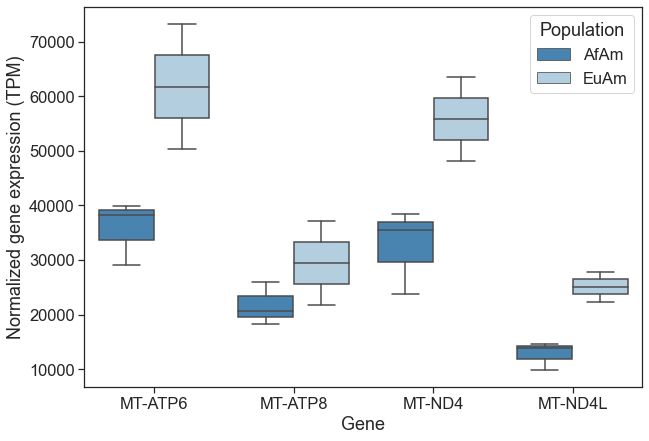

In [267]:
def boxplot_genes(df):
    sns.set(rc={'figure.figsize':(10,7)},font_scale=1.5)
    sns.set_style("ticks")
    sns.boxplot(data=df.sort_values(['Gene']) ,
               x='Gene' ,
               y='value',
               hue='Population',
               hue_order=['AfAm','EuAm'],
               palette="Blues_r"
               )
    plt.ylabel('Normalized gene expression (TPM)')
    plt.xticks(rotation=0)
    
boxplot_genes( df_orig[df_orig['Gene'].isin(['MT-ND4','MT-ND4L','MT-ATP8','MT-ATP6'])] )

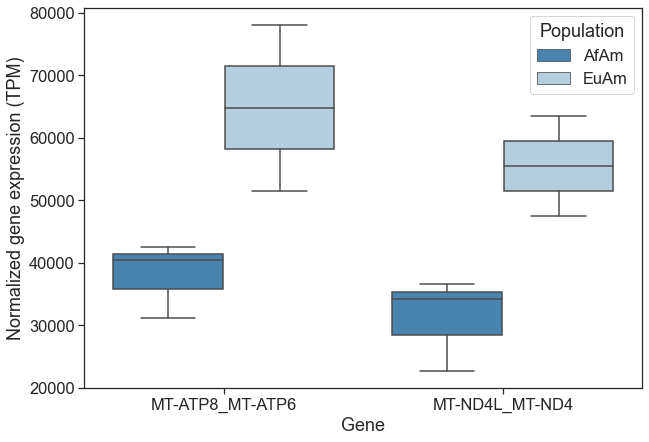

In [268]:
boxplot_genes( df_bic[df_bic['Gene'].isin(['MT-ND4L_MT-ND4','MT-ATP8_MT-ATP6'])] )

## Mann Whitney U test.

In [295]:
### Make table of the 'genes' compared across EuAm vs. AfAm, and 'p-values' of two-sided Mann-Whitney U test.
# Use only when the number of observation in each sample is > 20 and you have 2 independent samples of ranks. 
# Mann-Whitney U is significant if the u-obtained is LESS THAN or equal to the critical value of U.

def mwu_test(df,gene):
    data = df[df['Gene']==gene]
    data_euam = data[data['Population']=='EuAm']
    data_afam = data[data['Population']=='AfAm']
    #return(data_euam)
    results = stats.mannwhitneyu( pd.isnull(data_euam['value']) , pd.isnull(data_afam['value']) , alternative='greater')
    return(results)

#mwu_test(df_orig,'MT-ND4L')
#mwu_test(df_bic,'MT-ND4L_MT-ND4')

In [296]:
for gene in ['MT-ATP8_MT-ATP6','MT-ND4L_MT-ND4']:
    print(mwu_test(df_bic,gene), gene)

MannwhitneyuResult(statistic=3.0, pvalue=1.0) MT-ATP8_MT-ATP6
MannwhitneyuResult(statistic=3.0, pvalue=1.0) MT-ND4L_MT-ND4


In [297]:
for gene in ['MT-ATP8','MT-ATP6','MT-ND4L','MT-ND4']:
    print(mwu_test(df_orig,gene), gene)

MannwhitneyuResult(statistic=3.0, pvalue=1.0) MT-ATP8
MannwhitneyuResult(statistic=3.0, pvalue=1.0) MT-ATP6
MannwhitneyuResult(statistic=3.0, pvalue=1.0) MT-ND4L
MannwhitneyuResult(statistic=3.0, pvalue=1.0) MT-ND4


## Two sample t-test.

In [303]:
# This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. 
# This test assumes that the populations have identical variances by default.
## Apparently no minimum sample size, but power is severely limited.

def ttest_test(df,gene):
    data = df[df['Gene']==gene]
    data_euam = data[data['Population']=='EuAm']
    data_afam = data[data['Population']=='AfAm']
    #return(data_euam)
    results = stats.ttest_ind( data_euam['value'] , data_afam['value'] , alternative='greater')
    return(results)

In [304]:
for gene in ['MT-ATP8_MT-ATP6','MT-ND4L_MT-ND4']:
    print(ttest_test(df_bic,gene), gene)

Ttest_indResult(statistic=2.460201918422578, pvalue=0.045425620008172546) MT-ATP8_MT-ATP6
Ttest_indResult(statistic=2.9934487245256998, pvalue=0.028985433185288186) MT-ND4L_MT-ND4


In [305]:
for gene in ['MT-ATP8','MT-ATP6','MT-ND4L','MT-ND4']:
    print(ttest_test(df_orig,gene), gene)

Ttest_indResult(statistic=1.2170218849177041, pvalue=0.15530092101940762) MT-ATP8
Ttest_indResult(statistic=2.7171625513126045, pvalue=0.03636163194187859) MT-ATP6
Ttest_indResult(statistic=4.378253912989867, pvalue=0.011026726642290551) MT-ND4L
Ttest_indResult(statistic=2.8635265244285497, pvalue=0.03219531425179107) MT-ND4


## Correlate bicistronic transcript to single genes.

In [331]:
df_merged = pd.concat([ df_orig , df_bic ])
df_merged

,Description,Gene,value,Population,Tissue,short_ID,Sex,Mapping
0,SRR1074719,MT-ND1,34972.3,EuAm,Muscle - Skeletal,GTEX-XPVG,Male,Original
1,SRR1077288,MT-ND1,16752.3,AfAm,Muscle - Skeletal,GTEX-SSA3,Male,Original
2,SRR1077805,MT-ND1,19851.8,AfAm,Muscle - Skeletal,GTEX-XYKS,Female,Original
3,SRR1080766,MT-ND1,32457.1,EuAm,Muscle - Skeletal,GTEX-XUZC,Female,Original
5,SRR1365448,MT-ND1,20237.1,AfAm,Muscle - Skeletal,GTEX-11WQC,Male,Original
...,...,...,...,...,...,...,...,...
60,SRR1074719,MT-ND4L_MT-ND4,63458.3,EuAm,Muscle - Skeletal,GTEX-XPVG,Male,Bicistronic
61,SRR1077288,MT-ND4L_MT-ND4,22732.2,AfAm,Muscle - Skeletal,GTEX-SSA3,Male,Bicistronic
62,SRR1077805,MT-ND4L_MT-ND4,34206.9,AfAm,Muscle - Skeletal,GTEX-XYKS,Female,Bicistronic
63,SRR1080766,MT-ND4L_MT-ND4,47500.9,EuAm,Muscle - Skeletal,GTEX-XUZC,Female,Bicistronic


In [360]:
df_merged[df_merged['Gene'].isin(['MT-ATP8_MT-ATP6','MT-ND4L_MT-ND4','MT-ATP8','MT-ATP6','MT-ND4L','MT-ND4'])].iloc[:,:-1]

,Description,Gene,value,Population,Tissue,short_ID,Sex
24,SRR1074719,MT-ATP8,37170.2,EuAm,Muscle - Skeletal,GTEX-XPVG,Male
25,SRR1077288,MT-ATP8,18250.7,AfAm,Muscle - Skeletal,GTEX-SSA3,Male
26,SRR1077805,MT-ATP8,20734.6,AfAm,Muscle - Skeletal,GTEX-XYKS,Female
27,SRR1080766,MT-ATP8,21763.8,EuAm,Muscle - Skeletal,GTEX-XUZC,Female
29,SRR1365448,MT-ATP8,25909.9,AfAm,Muscle - Skeletal,GTEX-11WQC,Male
30,SRR1074719,MT-ATP6,73196.6,EuAm,Muscle - Skeletal,GTEX-XPVG,Male
31,SRR1077288,MT-ATP6,29118.7,AfAm,Muscle - Skeletal,GTEX-SSA3,Male
32,SRR1077805,MT-ATP6,38315.9,AfAm,Muscle - Skeletal,GTEX-XYKS,Female
33,SRR1080766,MT-ATP6,50287.8,EuAm,Muscle - Skeletal,GTEX-XUZC,Female
35,SRR1365448,MT-ATP6,39811.5,AfAm,Muscle - Skeletal,GTEX-11WQC,Male


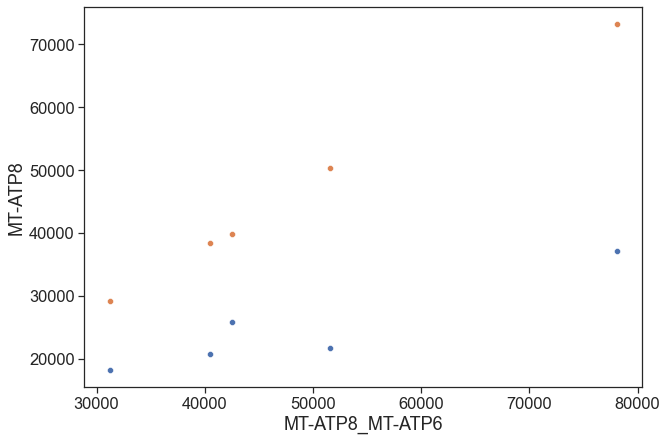

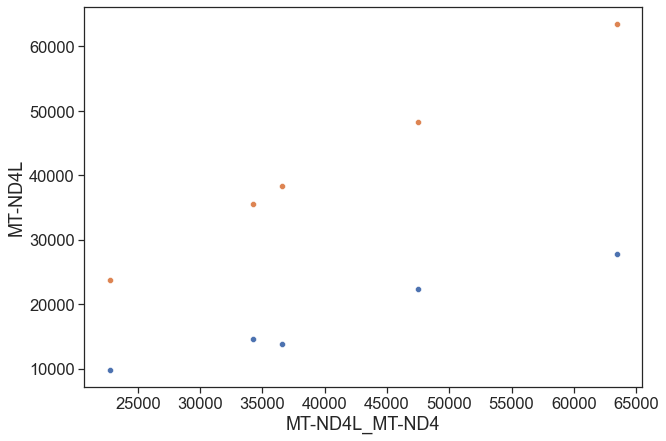

In [381]:
def test():
    data = df_merged[df_merged['Gene'].isin(['MT-ATP8_MT-ATP6','MT-ND4L_MT-ND4','MT-ATP8','MT-ATP6','MT-ND4L','MT-ND4'])].iloc[:,:-1]
    data = data[['Description','Gene','value']].pivot(index='Description', columns='Gene')
    #return( data )
    sns.scatterplot( data=data['value'] ,
                    x='MT-ATP8_MT-ATP6' , 
                    y='MT-ATP8' )
    sns.scatterplot( data=data['value'] ,
                    x='MT-ATP8_MT-ATP6' , 
                    y='MT-ATP6' )
    plt.show()
    
    sns.scatterplot( data=data['value'] ,
                    x='MT-ND4L_MT-ND4' , 
                    y='MT-ND4L' )
    sns.scatterplot( data=data['value'] ,
                    x='MT-ND4L_MT-ND4' , 
                    y='MT-ND4' )
    plt.show()
    
test()